In [27]:
import os
# Find the latest version of spark 3.x  from https://downloads.apache.org/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.1'
spark_version = 'spark-3.5.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [28]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("breastcancer").getOrCreate()


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
dir = '/content/drive/MyDrive/machine-learning-project/data/'

In [31]:
# Path to train CSV file in Google Drive
file_path = '/content/drive/MyDrive/machine-learning-project/data/mass_case_description_train_set.csv'

# Read the CSV file into a DataFrame
df_train = spark.read.option('header', 'true').csv(file_path, inferSchema=True, sep=',')

# Show the DataFrame
df_train.show()

+----------+--------------+--------------------+----------+--------------+----------------+--------------------+--------------------+----------+---------+--------+--------------------+-----------------------+--------------------+
|patient_id|breast_density|left or right breast|image view|abnormality id|abnormality type|          mass shape|        mass margins|assessment|pathology|subtlety|     image file path|cropped image file path|  ROI mask file path|
+----------+--------------+--------------------+----------+--------------+----------------+--------------------+--------------------+----------+---------+--------+--------------------+-----------------------+--------------------+
|   P_00001|             3|                LEFT|        CC|             1|            mass|IRREGULAR-ARCHITE...|          SPICULATED|         4|MALIGNANT|       4|Mass-Training_P_0...|   Mass-Training_P_0...|Mass-Training_P_0...|
|         "|          NULL|                NULL|      NULL|          NULL|      

In [32]:
# Path to your CSV file in Google Drive
file_path = '/content/drive/MyDrive/machine-learning-project/data/mass_case_description_test_set.csv'

# Read the CSV file into a DataFrame
df_test = spark.read.option('header', 'true').csv(file_path, inferSchema=True, sep=',')

# Show the DataFrame
df_test.show()

+----------+--------------+--------------------+----------+--------------+----------------+----------+-------------+----------+---------+--------+--------------------+-----------------------+--------------------+
|patient_id|breast_density|left or right breast|image view|abnormality id|abnormality type|mass shape| mass margins|assessment|pathology|subtlety|     image file path|cropped image file path|  ROI mask file path|
+----------+--------------+--------------------+----------+--------------+----------------+----------+-------------+----------+---------+--------+--------------------+-----------------------+--------------------+
|   P_00016|             4|                LEFT|        CC|             1|            mass| IRREGULAR|   SPICULATED|         5|MALIGNANT|       5|Mass-Test_P_00016...|   Mass-Test_P_00016...|Mass-Test_P_00016...|
|         "|          NULL|                NULL|      NULL|          NULL|            NULL|      NULL|         NULL|      NULL|     NULL|    NULL|  

In [33]:
from pyspark.sql.functions import concat, col, lit

# Create the 'identifier' column by concatenating the specified columns with underscores
df_train = df_train.withColumn(
    'identifier',
    concat(
        col('patient_id').cast('string'),
        lit('_'),
        col('left or right breast').cast('string'),
        lit('_'),
        col('image view').cast('string'),
        lit('_'),
        col('abnormality id').cast('string')
    )
)

# Show the DataFrame
df_train.show()

+----------+--------------+--------------------+----------+--------------+----------------+--------------------+--------------------+----------+---------+--------+--------------------+-----------------------+--------------------+-------------------+
|patient_id|breast_density|left or right breast|image view|abnormality id|abnormality type|          mass shape|        mass margins|assessment|pathology|subtlety|     image file path|cropped image file path|  ROI mask file path|         identifier|
+----------+--------------+--------------------+----------+--------------+----------------+--------------------+--------------------+----------+---------+--------+--------------------+-----------------------+--------------------+-------------------+
|   P_00001|             3|                LEFT|        CC|             1|            mass|IRREGULAR-ARCHITE...|          SPICULATED|         4|MALIGNANT|       4|Mass-Training_P_0...|   Mass-Training_P_0...|Mass-Training_P_0...|  P_00001_LEFT_CC_1|


In [34]:
# Drop the specified columns from the DataFrame
df_train = df_train.drop(
    'patient_id',
    'left or right breast',
    'image view',
    'abnormality id',
    'abnormality type',
    'image file path',
    'cropped image file path',
    'ROI mask file path'
)

# Show the DataFrame
df_train.show()

+--------------+--------------------+--------------------+----------+---------+--------+-------------------+
|breast_density|          mass shape|        mass margins|assessment|pathology|subtlety|         identifier|
+--------------+--------------------+--------------------+----------+---------+--------+-------------------+
|             3|IRREGULAR-ARCHITE...|          SPICULATED|         4|MALIGNANT|       4|  P_00001_LEFT_CC_1|
|          NULL|                NULL|                NULL|      NULL|     NULL|    NULL|               NULL|
|             3|IRREGULAR-ARCHITE...|          SPICULATED|         4|MALIGNANT|       4| P_00001_LEFT_MLO_1|
|          NULL|                NULL|                NULL|      NULL|     NULL|    NULL|               NULL|
|             3|ARCHITECTURAL_DIS...|         ILL_DEFINED|         4|   BENIGN|       3|  P_00004_LEFT_CC_1|
|          NULL|                NULL|                NULL|      NULL|     NULL|    NULL|               NULL|
|             3|ARC

In [35]:
# Reorder the columns in the specified order
df_train = df_train.select(
    'identifier',
    'mass shape',
    'mass margins',
    'breast_density',
    'assessment',
    'subtlety',
    'pathology'
)

# Show the DataFrame
df_train.show()

+-------------------+--------------------+--------------------+--------------+----------+--------+---------+
|         identifier|          mass shape|        mass margins|breast_density|assessment|subtlety|pathology|
+-------------------+--------------------+--------------------+--------------+----------+--------+---------+
|  P_00001_LEFT_CC_1|IRREGULAR-ARCHITE...|          SPICULATED|             3|         4|       4|MALIGNANT|
|               NULL|                NULL|                NULL|          NULL|      NULL|    NULL|     NULL|
| P_00001_LEFT_MLO_1|IRREGULAR-ARCHITE...|          SPICULATED|             3|         4|       4|MALIGNANT|
|               NULL|                NULL|                NULL|          NULL|      NULL|    NULL|     NULL|
|  P_00004_LEFT_CC_1|ARCHITECTURAL_DIS...|         ILL_DEFINED|             3|         4|       3|   BENIGN|
|               NULL|                NULL|                NULL|          NULL|      NULL|    NULL|     NULL|
| P_00004_LEFT_MLO_

In [36]:

from pyspark.sql.functions import when

# Reclassify the values in the 'pathology' column
df_train = df_train.withColumn(
    'pathology',
    when(df_train['pathology'] == 'BENIGN', 0)
    .when(df_train['pathology'] == 'BENIGN_WITHOUT_CALLBACK', 1)
    .when(df_train['pathology'] == 'MALIGNANT', 2)
    .otherwise(df_train['pathology'])
)

# Show the DataFrame
df_train.show()

+-------------------+--------------------+--------------------+--------------+----------+--------+---------+
|         identifier|          mass shape|        mass margins|breast_density|assessment|subtlety|pathology|
+-------------------+--------------------+--------------------+--------------+----------+--------+---------+
|  P_00001_LEFT_CC_1|IRREGULAR-ARCHITE...|          SPICULATED|             3|         4|       4|        2|
|               NULL|                NULL|                NULL|          NULL|      NULL|    NULL|     NULL|
| P_00001_LEFT_MLO_1|IRREGULAR-ARCHITE...|          SPICULATED|             3|         4|       4|        2|
|               NULL|                NULL|                NULL|          NULL|      NULL|    NULL|     NULL|
|  P_00004_LEFT_CC_1|ARCHITECTURAL_DIS...|         ILL_DEFINED|             3|         4|       3|        0|
|               NULL|                NULL|                NULL|          NULL|      NULL|    NULL|     NULL|
| P_00004_LEFT_MLO_

In [37]:
from pyspark.sql.functions import concat, col, lit

# Create the 'identifier' column by concatenating the specified columns with underscores
df_test = df_test.withColumn(
    'identifier',
    concat(
        col('patient_id').cast('string'),
        lit('_'),
        col('left or right breast').cast('string'),
        lit('_'),
        col('image view').cast('string'),
        lit('_'),
        col('abnormality id').cast('string')
    )
)

# Show the DataFrame
df_test.show()

+----------+--------------+--------------------+----------+--------------+----------------+----------+-------------+----------+---------+--------+--------------------+-----------------------+--------------------+-------------------+
|patient_id|breast_density|left or right breast|image view|abnormality id|abnormality type|mass shape| mass margins|assessment|pathology|subtlety|     image file path|cropped image file path|  ROI mask file path|         identifier|
+----------+--------------+--------------------+----------+--------------+----------------+----------+-------------+----------+---------+--------+--------------------+-----------------------+--------------------+-------------------+
|   P_00016|             4|                LEFT|        CC|             1|            mass| IRREGULAR|   SPICULATED|         5|MALIGNANT|       5|Mass-Test_P_00016...|   Mass-Test_P_00016...|Mass-Test_P_00016...|  P_00016_LEFT_CC_1|
|         "|          NULL|                NULL|      NULL|         

In [38]:
# Drop the specified columns from the DataFrame
df_test = df_test.drop(
    'patient_id',
    'left or right breast',
    'image view',
    'abnormality id',
    'abnormality type',
    'image file path',
    'cropped image file path',
    'ROI mask file path'
)

# Show the DataFrame
df_test.show()

+--------------+----------+-------------+----------+---------+--------+-------------------+
|breast_density|mass shape| mass margins|assessment|pathology|subtlety|         identifier|
+--------------+----------+-------------+----------+---------+--------+-------------------+
|             4| IRREGULAR|   SPICULATED|         5|MALIGNANT|       5|  P_00016_LEFT_CC_1|
|          NULL|      NULL|         NULL|      NULL|     NULL|    NULL|               NULL|
|             4| IRREGULAR|   SPICULATED|         5|MALIGNANT|       5| P_00016_LEFT_MLO_1|
|          NULL|      NULL|         NULL|      NULL|     NULL|    NULL|               NULL|
|             2|     ROUND|CIRCUMSCRIBED|         4|MALIGNANT|       4|  P_00017_LEFT_CC_1|
|          NULL|      NULL|         NULL|      NULL|     NULL|    NULL|               NULL|
|             2|     ROUND|  ILL_DEFINED|         4|MALIGNANT|       4| P_00017_LEFT_MLO_1|
|          NULL|      NULL|         NULL|      NULL|     NULL|    NULL|         

In [39]:
# Reorder the columns in the specified order
df_test = df_test.select(
    'identifier',
    'mass shape',
    'mass margins',
    'breast_density',
    'assessment',
    'subtlety',
    'pathology'
)

# Show the DataFrame
df_test.show()

+-------------------+----------+-------------+--------------+----------+--------+---------+
|         identifier|mass shape| mass margins|breast_density|assessment|subtlety|pathology|
+-------------------+----------+-------------+--------------+----------+--------+---------+
|  P_00016_LEFT_CC_1| IRREGULAR|   SPICULATED|             4|         5|       5|MALIGNANT|
|               NULL|      NULL|         NULL|          NULL|      NULL|    NULL|     NULL|
| P_00016_LEFT_MLO_1| IRREGULAR|   SPICULATED|             4|         5|       5|MALIGNANT|
|               NULL|      NULL|         NULL|          NULL|      NULL|    NULL|     NULL|
|  P_00017_LEFT_CC_1|     ROUND|CIRCUMSCRIBED|             2|         4|       4|MALIGNANT|
|               NULL|      NULL|         NULL|          NULL|      NULL|    NULL|     NULL|
| P_00017_LEFT_MLO_1|     ROUND|  ILL_DEFINED|             2|         4|       4|MALIGNANT|
|               NULL|      NULL|         NULL|          NULL|      NULL|    NULL

In [40]:
from pyspark.sql.functions import when

# Reclassify the values in the 'pathology' column
df_test = df_test.withColumn(
    'pathology',
    when(df_test['pathology'] == 'BENIGN', 0)
    .when(df_test['pathology'] == 'BENIGN_WITHOUT_CALLBACK', 1)
    .when(df_test['pathology'] == 'MALIGNANT', 2)
    .otherwise(df_test['pathology'])
)

# Show the DataFrame
df_test.show()

+-------------------+----------+-------------+--------------+----------+--------+---------+
|         identifier|mass shape| mass margins|breast_density|assessment|subtlety|pathology|
+-------------------+----------+-------------+--------------+----------+--------+---------+
|  P_00016_LEFT_CC_1| IRREGULAR|   SPICULATED|             4|         5|       5|        2|
|               NULL|      NULL|         NULL|          NULL|      NULL|    NULL|     NULL|
| P_00016_LEFT_MLO_1| IRREGULAR|   SPICULATED|             4|         5|       5|        2|
|               NULL|      NULL|         NULL|          NULL|      NULL|    NULL|     NULL|
|  P_00017_LEFT_CC_1|     ROUND|CIRCUMSCRIBED|             2|         4|       4|        2|
|               NULL|      NULL|         NULL|          NULL|      NULL|    NULL|     NULL|
| P_00017_LEFT_MLO_1|     ROUND|  ILL_DEFINED|             2|         4|       4|        2|
|               NULL|      NULL|         NULL|          NULL|      NULL|    NULL

In [41]:
# Separate features (X) and target (y) for training
X_train = df_train.drop('pathology')  # Drop the 'pathology' column to get the features
y_train = df_train.select('pathology')  # Select the 'pathology' column as the target variable

# Separate features (X) and target (y) for testing
X_test = df_test.drop('pathology')  # Drop the 'pathology' column to get the features
y_test = df_test.select('pathology')  # Select the 'pathology' column as the target variable

In [42]:
# Convert PySpark DataFrames to Pandas DataFrames
X_train_pd = X_train.toPandas()
y_train_pd = y_train.toPandas()
X_test_pd = X_test.toPandas()
y_test_pd = y_test.toPandas()

In [43]:
# Drop rows with NaN values
X_train_pd = X_train_pd.dropna()
y_train_pd = y_train_pd.loc[X_train_pd.index]  # Ensure y_train_pd stays aligned with X_train_pd

X_test_pd = X_test_pd.dropna()
y_test_pd = y_test_pd.loc[X_test_pd.index]  # Ensure y_test_pd stays aligned with X_test_pd

In [44]:
import pandas as pd
X_train_pd = pd.get_dummies(X_train_pd)
X_test_pd = pd.get_dummies(X_test_pd)

# Align columns in train and test sets (ensure they have the same features)
X_train_pd, X_test_pd = X_train_pd.align(X_test_pd, axis=1, fill_value=0)


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

scaler = StandardScaler()
X_train_pd = scaler.fit_transform(X_train_pd)
X_test_pd = scaler.transform(X_test_pd)



In [46]:

# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train_pd, y_train_pd.values.ravel())  # Ensure y_train_pd is a 1D array

KNeighborsClassifier()

In [47]:

# Predict on the test set
y_pred = knn.predict(X_test_pd)

In [48]:
# Accuracy
print("Accuracy:", accuracy_score(y_test_pd, y_pred))

# Detailed Classification Report
print("Classification Report:\n", classification_report(y_test_pd, y_pred))


Accuracy: 0.7407407407407407
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.78       194
           1       0.94      0.41      0.57        37
           2       0.68      0.78      0.73       147

    accuracy                           0.74       378
   macro avg       0.80      0.65      0.69       378
weighted avg       0.76      0.74      0.74       378



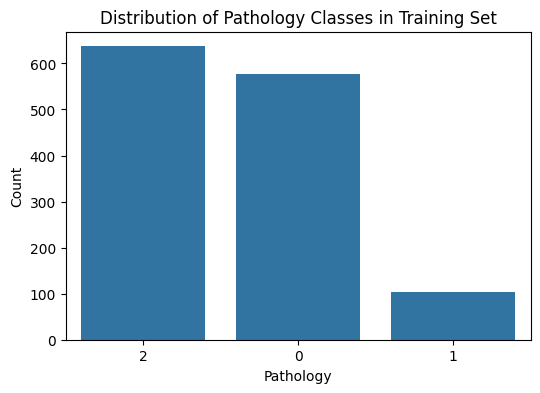

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of the 'pathology' classes
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_pd['pathology'])
plt.title('Distribution of Pathology Classes in Training Set')
plt.xlabel('Pathology')
plt.ylabel('Count')
plt.show()



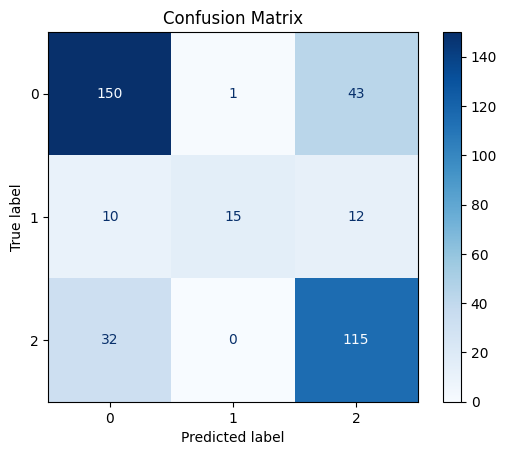

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test_pd, y_pred)

# Convert the confusion matrix to a DataFrame
cm_df = pd.DataFrame(cm, index=[f"Actual_{i}" for i in range(len(cm))],
                     columns=[f"Predicted_{i}" for i in range(len(cm[0]))])

# Save the DataFrame to a CSV file
cm_df.to_csv('/content/confusion_matrix_knn2.csv', index=True)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [51]:
from google.colab import files
files.download('/content/confusion_matrix_knn2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
from sklearn.metrics import classification_report
import pandas as pd

print(classification_report(y_test_pd, y_pred))

# Generate the classification report as a dictionary
report = classification_report(y_test_pd, y_pred, output_dict=True)

# Convert the report dictionary to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Save the DataFrame to a CSV file
report_df.to_csv('/content/classification_report_knn2.csv', index=True)



              precision    recall  f1-score   support

           0       0.78      0.77      0.78       194
           1       0.94      0.41      0.57        37
           2       0.68      0.78      0.73       147

    accuracy                           0.74       378
   macro avg       0.80      0.65      0.69       378
weighted avg       0.76      0.74      0.74       378



In [56]:
from google.colab import files
files.download('/content/classification_report_knn2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Example: Cross-validation with Random Forest
rf = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(rf, X_train_pd, y_train_pd.values.ravel(), cv=5)
print("Random Forest CV Accuracy: {:.2f} ± {:.2f}".format(cv_scores.mean(), cv_scores.std()))


Random Forest CV Accuracy: 0.80 ± 0.05
